# Probabilistic LSTM Forecasting for SDE-Driven Time Series
Author: Alireza Samari
#### Time Series Forecasting with Probabilistic LSTMs: A Wiener Process Case Study

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

## Step 1: Data Simulation via Stochastic Differential Equation

We simulate a time series $X_t$ governed by the Itô Stochastic Differential Equation (SDE):

$dX_t = \mu dt + \sigma dW_t$

where:
- $\mu$ is the constant drift coefficient.
- $\sigma$ is the constant diffusion coefficient.
- $dW_t$ is an increment of a Wiener process, $dW_t \sim \mathcal{N}(0, dt)$.

The simulation uses the Euler-Maruyama method, a first-order numerical procedure for SDEs. For a discrete time step $\Delta t$, the update rule is:

$X_{t_{i+1}} = X_{t_i} + \mu \Delta t + \sigma \sqrt{\Delta t} Z_i$

where $Z_i \sim \mathcal{N}(0, 1)$ are independent standard normal random variables. This generates a sequence of values $(X_{t_0}, X_{t_1}, ..., X_{t_N})$.

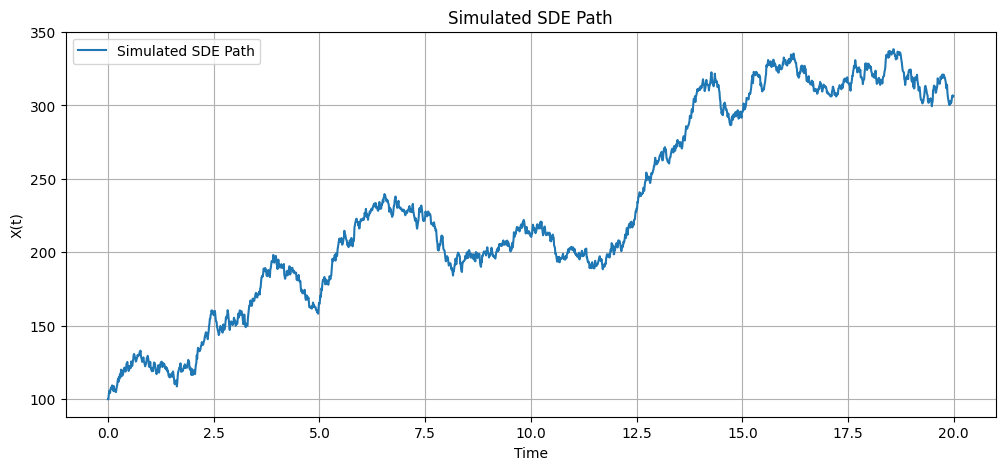

In [ ]:
def simulate_sde_path(num_samples, drift_true, diffusion_true, dt=0.01, initial_value=100):
    time_points = np.arange(0, num_samples * dt, dt)
    dW = np.random.normal(0, np.sqrt(dt), size=num_samples)
    x_path = np.zeros(num_samples)
    x_path[0] = initial_value
    for i in range(1, num_samples):
        x_path[i] = x_path[i-1] + drift_true * dt + diffusion_true * dW[i-1]
    return time_points, x_path

num_samples = 2000
true_drift_val = 10
true_diffusion_val = 20
dt = 0.01

time_np, x_np = simulate_sde_path(num_samples, true_drift_val, true_diffusion_val, dt)
x_np_reshaped = x_np.reshape(-1, 1)

plt.figure(figsize=(12, 5))
plt.plot(time_np, x_np, label="Simulated SDE Path")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.title("Simulated SDE Path")
plt.legend()
plt.grid(True)
plt.show()

## Step 2: Data Preprocessing for Time Series Sequence Modeling

The simulated time series data $X_t$ is scaled to the range $[0, 1]$. This is a common practice that can improve the stability and performance of neural network training. If $X_{\text{min}}$ and $X_{\text{max}}$ are the minimum and maximum values of the original data $X_t$, the **Min-Max scaling** transformation is:

$X'_{\text{scaled}} = \frac{X_t - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}$

This yields the scaled time series $X'_t$.

To train a model to predict future values, the scaled time series $X'_0, X'_1, \ldots, X'_{N-1}$ is converted into input-output pairs. Given a fixed `sequence_length` $L$:
-   An **input sequence** $S_k$ is formed by $L$ consecutive scaled data points: $S_k = (X'_{k}, X'_{k+1}, \ldots, X'_{k+L-1})$
-   The corresponding **target value** $Y_k$ is the scaled data point immediately following the input sequence: $Y_k = X'_{k+L}$

This process generates a dataset where each sample consists of a historical sequence $S_k$ and the value $Y_k$ to be predicted.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))


def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


split_idx = int(len(x_np_reshaped) * 0.8)
x_raw_train_data = x_np_reshaped[:split_idx]
x_raw_test_data = x_np_reshaped[split_idx:]

scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled_train = scaler.fit_transform(x_raw_train_data)
x_scaled_test = scaler.transform(x_raw_test_data)

sequence_length = 20
X_train, y_train = create_sequences(x_scaled_train, sequence_length)
X_test, y_test = create_sequences(x_scaled_test, sequence_length)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Step 3: Defining the Probabilistic LSTM Model

The model has two output values, which represent the parameters of a Gaussian distribution for the predicted next scaled value $X'_{k+L}$:
1.  $\hat{\mu}'_{k+L}$: The predicted mean of the Gaussian distribution.
2.  $\log(\hat{\sigma}'^2_{k+L})$: The predicted logarithm of the variance of the Gaussian distribution. Predicting log-variance ensures $\hat{\sigma}'^2$ is positive and aids in numerical stability during training.

So, for each input sequence $S_k$, the model outputs a pair $(\hat{\mu}'_{k+L}, \log(\hat{\sigma}'^2_{k+L}))$.

In [ ]:
class ProbabilisticLSTMForecaster(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, num_layers=1, output_params=2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_layer_size,
                            num_layers=num_layers,
                            batch_first=True)

        # Output layer: mean and log_variance
        self.linear = nn.Linear(hidden_layer_size, output_params)

    def forward(self, input_seq):
        h_0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)
        c_0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)
        lstm_out, _ = self.lstm(input_seq, (h_0, c_0))
        predictions_params = self.linear(lstm_out[:, -1, :])
        return predictions_params
model = ProbabilisticLSTMForecaster(input_size=1, hidden_layer_size=50, num_layers=2, output_params=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ProbabilisticLSTMForecaster(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

## Step 4: Defining The Hybrid Loss Function

Our model will be trained using a hybrid loss function composed of three distinct terms. Each term encourages the model to learn different aspects of the time series: its next value distribution, the accuracy of its mean prediction, and its consistency with the underlying stochastic process generating the data.

### 4.1 Gaussian Negative Log-Likelihood (NLL) Component

This component evaluates how well the predicted Gaussian distribution for the next scaled value $Y_k$ (which is $X'_{k+L}$) matches the true observed value. The model outputs parameters for this distribution: the mean $\hat{\mu}'_k$ (predicting $Y_k$) and the log-variance $\log(\hat{\sigma}'^2_k)$.

The probability density function (PDF) of $Y_k$ under the predicted Gaussian $\mathcal{N}(\hat{\mu}'_k, \hat{\sigma}'^2_k)$ is:

$p(Y_k | \hat{\mu}'_k, \hat{\sigma}'^2_k) = \frac{1}{\sqrt{2\pi\hat{\sigma}'^2_k}} \exp\left(-\frac{(Y_k - \hat{\mu}'_k)^2}{2\hat{\sigma}'^2_k}\right)$

The log-likelihood is:

$\log p(Y_k | \hat{\mu}'_k, \hat{\sigma}'^2_k) = -\frac{1}{2}\log(2\pi) - \frac{1}{2}\log(\hat{\sigma}'^2_k) - \frac{(Y_k - \hat{\mu}'_k)^2}{2\hat{\sigma}'^2_k}$

The Negative Log-Likelihood (NLL) loss for a single data point $k$ is then:

$L_{\text{NLL}}(Y_k, \hat{\mu}'_k, \log(\hat{\sigma}'^2_k)) = \frac{1}{2}\left(\log(2\pi) + \log(\hat{\sigma}'^2_k) + \frac{(Y_k - \hat{\mu}'_k)^2}{\exp(\log(\hat{\sigma}'^2_k))}\right)$

Minimizing this encourages $\hat{\mu}'_k$ to be close to $Y_k$ and $\hat{\sigma}'^2_k$ to reflect the actual uncertainty.

### 4.2 Mean Squared Error (MSE) on Mean Prediction Component

This standard regression loss focuses on the accuracy of the predicted mean $\hat{\mu}'_k$ against the true scaled target value $Y_k$:

$L_{\text{MSE}}(Y_k, \hat{\mu}'_k) = (Y_k - \hat{\mu}'_k)^2$

This term specifically pushes the model's mean prediction towards the actual value.

### 4.3 SDE Parameter Consistency Component

This component aims to make the LSTM's predictions consistent with the known parameters of the underlying Stochastic Differential Equation ($dX_t = \mu_{\text{true}} dt + \sigma_{\text{true}} dW_t$) when translated to the scaled domain.

Let $X'_{prev}$ be the last observed scaled value in the input sequence that leads to the prediction of $Y_k$. The LSTM's prediction for $Y_k \sim \mathcal{N}(\hat{\mu}'_k, \hat{\sigma}'^2_k)$ implies parameters for the scaled increment $\Delta X'_{\text{implied}} = Y_k - X'_{prev}$:
-   Predicted mean of scaled increment: $\hat{m}'_{\Delta,k} = \hat{\mu}'_k - X'_{prev}$
-   Predicted variance of scaled increment: $\hat{v}'_{\Delta,k} = \hat{\sigma}'^2_k = \exp(\log(\hat{\sigma}'^2_k))$

The target parameters for the scaled increment over one time step $\Delta t$, derived from the true SDE parameters and the scaling factor $a = \text{scaler.scale_}[0]$, are:
-   Target mean of scaled increment: $m'_{\Delta, \text{target}} = (a \cdot \mu_{\text{true}}) \cdot \Delta t$
-   Target variance of scaled increment: $v'_{\Delta, \text{target}} = (a \cdot \sigma_{\text{true}})^2 \cdot \Delta t$

The SDE consistency loss for data point $k$ is then defined using MSE terms for these implied increment parameters:

$L_{\text{SDE-Consist},k} = \lambda_{\text{drift}} \cdot (\hat{m}'_{\Delta,k} - m'_{\Delta, \text{target}})^2 + \lambda_{\text{diffusion}} \cdot (\hat{v}'_{\Delta,k} - v'_{\Delta, \text{target}})^2$

where $\lambda_{\text{drift}}$ and $\lambda_{\text{diffusion}}$ are weighting hyperparameters.

### 4.4 Total Hybrid Loss Function

The overall loss function $L_{\text{total},k}$ for a single data point $k$ is a weighted sum of these three components:

$L_{\text{total},k} = L_{\text{NLL}}(Y_k, \hat{\mu}'_k, \log(\hat{\sigma}'^2_k)) + \lambda_{\text{MSE}} \cdot L_{\text{MSE}}(Y_k, \hat{\mu}'_k) + L_{\text{SDE-Consist},k}$

During training, the objective is to minimize the average of $L_{\text{total},k}$ over all data points in a batch $B$:

$L_{\text{batch}} = \frac{1}{B} \sum_{k=1}^{B} L_{\text{total},k}$

The hyperparameters $\lambda_{\text{MSE}}$, $\lambda_{\text{drift}}$, and $\lambda_{\text{diffusion}}$ control the relative influence of each term in the total loss.

# Step 5: Training the Model

Starting training with Hybrid Loss (NLL + MSE (lambda=0.5) + SDE Consist (drift_lambda=0.1, diff_lambda=0.1))...
Target scaled increment mean (for SDE loss): 0.000430
Target scaled increment variance (for SDE loss): 0.000074
Epoch [10/300], Total Loss: -2.378606 (NLL: -2.378831, MSE: 0.000387, SDE Drift: 0.000312, SDE Diff: 0.000001)
Epoch [20/300], Total Loss: -2.437536 (NLL: -2.437793, MSE: 0.000442, SDE Drift: 0.000358, SDE Diff: 0.000000)
Epoch [30/300], Total Loss: -2.596948 (NLL: -2.597118, MSE: 0.000296, SDE Drift: 0.000223, SDE Diff: 0.000000)
Epoch [40/300], Total Loss: -2.454915 (NLL: -2.455162, MSE: 0.000424, SDE Drift: 0.000346, SDE Diff: 0.000000)
Epoch [50/300], Total Loss: -2.652714 (NLL: -2.652878, MSE: 0.000286, SDE Drift: 0.000209, SDE Diff: 0.000000)
Epoch [60/300], Total Loss: -2.573657 (NLL: -2.573850, MSE: 0.000336, SDE Drift: 0.000257, SDE Diff: 0.000000)
Epoch [70/300], Total Loss: -2.832020 (NLL: -2.832132, MSE: 0.000201, SDE Drift: 0.000123, SDE Diff: 0.000000

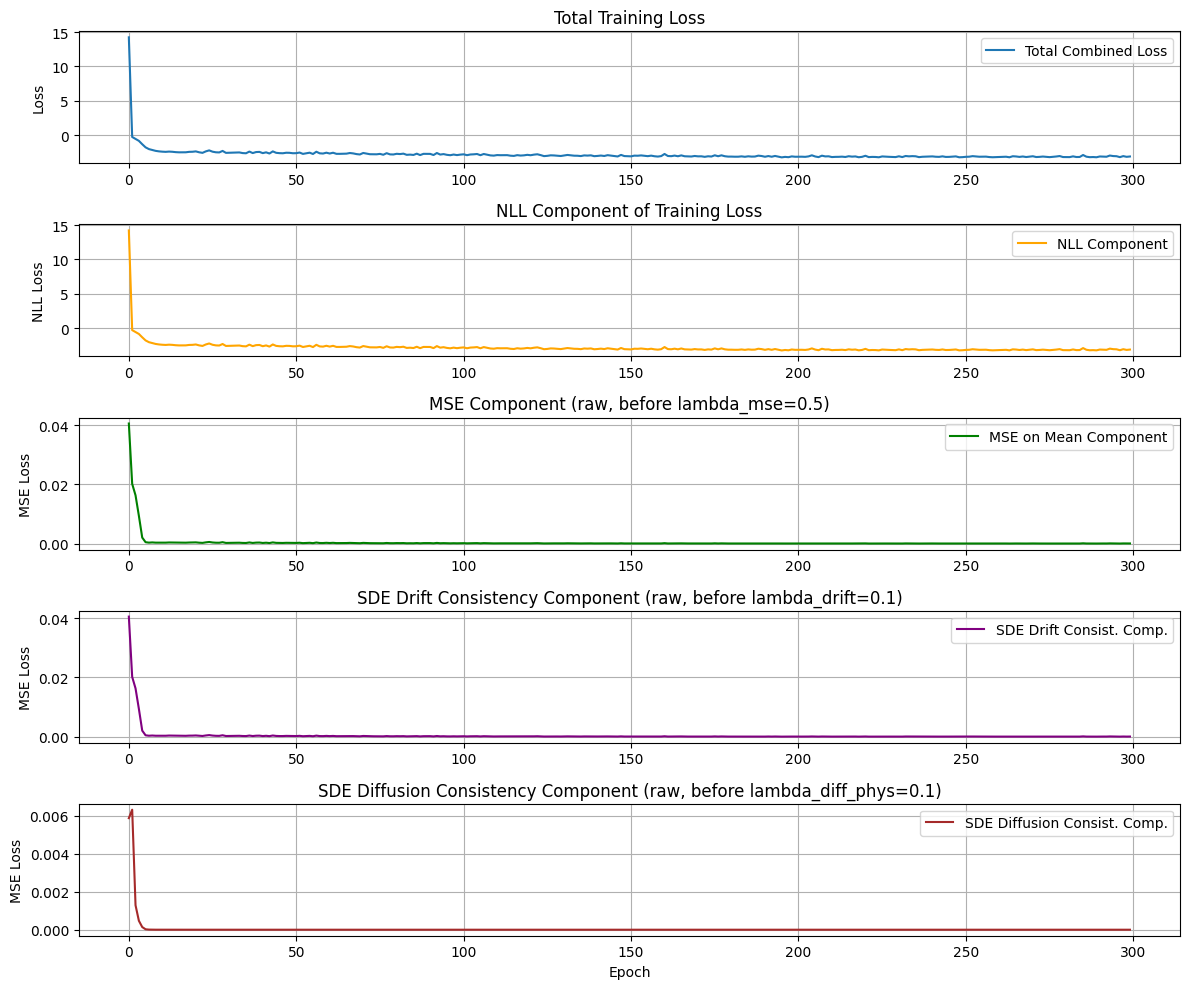

In [ ]:
def gaussian_nll_loss(outputs, targets):

    mu_pred = outputs[:, 0:1]
    log_var_pred = outputs[:, 1:2]

    variance_pred = torch.exp(log_var_pred)
    pi_tensor = torch.tensor(2.0 * np.pi, device=outputs.device)

    nll = 0.5 * (torch.log(pi_tensor) + log_var_pred + ((targets - mu_pred)**2) / variance_pred)
    return nll.mean()

mse_loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


lambda_mse = 0.5            # Weight for MSE on mean prediction
lambda_drift = 0.1     # Weight for SDE drift consistency
lambda_diffusion = 0.1 # Weight for SDE diffusion consistency

num_epochs = 300
train_losses_total = []
train_losses_nll = []
train_losses_mse = []
train_losses_sde_drift = []
train_losses_sde_diffusion = []
a_scaling_factor = scaler.scale_[0]

target_mean_increment_scaled_val = (a_scaling_factor * true_drift_val) * dt
target_var_increment_scaled_val = ((a_scaling_factor * true_diffusion_val)**2) * dt


print(f"Starting training with Hybrid Loss (NLL + MSE (lambda={lambda_mse}) + SDE Consist (drift_lambda={lambda_drift}, diff_lambda={lambda_diffusion}))...")
print(f"Target scaled increment mean (for SDE loss): {target_mean_increment_scaled_val:.6f}")
print(f"Target scaled increment variance (for SDE loss): {target_var_increment_scaled_val:.6f}")

for epoch in range(num_epochs):
    model.train()
    epoch_total_loss_val = 0
    epoch_nll_loss_val = 0
    epoch_mse_loss_val = 0
    epoch_sde_drift_loss_val = 0
    epoch_sde_diffusion_loss_val = 0

    for batch_idx, (sequences, targets) in enumerate(train_loader):
        sequences, targets = sequences.to(device), targets.to(device)

        output_params = model(sequences)
        mu_pred_scaled_next_val = output_params[:, 0:1]
        log_var_pred_scaled_next_val = output_params[:, 1:2]
        var_pred_scaled_next_val = torch.exp(log_var_pred_scaled_next_val)

        # 1. NLL
        nll_component = gaussian_nll_loss(output_params, targets)

        # 2. MSE
        mse_component = mse_loss_fn(mu_pred_scaled_next_val, targets)

        # 3. SDE
        last_observed_scaled = sequences[:, -1, 0:1]

        # Predicted parameters
        mean_increment_scaled_pred = mu_pred_scaled_next_val - last_observed_scaled
        var_increment_scaled_pred = var_pred_scaled_next_val # Variance of X_next is var of increment if X_current is known

        # Target tensors for SDE consistency loss
        target_mean_inc_tensor = torch.full_like(mean_increment_scaled_pred, target_mean_increment_scaled_val, device=device)
        target_var_inc_tensor = torch.full_like(var_increment_scaled_pred, target_var_increment_scaled_val, device=device)

        loss_drift = mse_loss_fn(mean_increment_scaled_pred, target_mean_inc_tensor)
        loss_diffusion = mse_loss_fn(var_increment_scaled_pred, target_var_inc_tensor)

        sde_consistency_component = lambda_drift * loss_drift + lambda_diffusion * loss_diffusion

        # Total Loss
        total_loss = nll_component + lambda_mse * mse_component + sde_consistency_component

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_total_loss_val += total_loss.item()
        epoch_nll_loss_val += nll_component.item()
        epoch_mse_loss_val += mse_component.item()
        epoch_sde_drift_loss_val += loss_drift.item()
        epoch_sde_diffusion_loss_val += loss_diffusion.item()

    avg_epoch_total_loss = epoch_total_loss_val / len(train_loader)
    avg_epoch_nll_loss = epoch_nll_loss_val / len(train_loader)
    avg_epoch_mse_loss = epoch_mse_loss_val / len(train_loader)
    avg_epoch_sde_drift_loss = epoch_sde_drift_loss_val / len(train_loader)
    avg_epoch_sde_diffusion_loss = epoch_sde_diffusion_loss_val / len(train_loader)

    train_losses_total.append(avg_epoch_total_loss)
    train_losses_nll.append(avg_epoch_nll_loss)
    train_losses_mse.append(avg_epoch_mse_loss)
    train_losses_sde_drift.append(avg_epoch_sde_drift_loss)
    train_losses_sde_diffusion.append(avg_epoch_sde_diffusion_loss)

    if (epoch + 1) % 10 == 0 or epoch == num_epochs -1:
        print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {avg_epoch_total_loss:.6f} "
              f"(NLL: {avg_epoch_nll_loss:.6f}, MSE: {avg_epoch_mse_loss:.6f}, "
              f"SDE Drift: {avg_epoch_sde_drift_loss:.6f}, SDE Diff: {avg_epoch_sde_diffusion_loss:.6f})")

print("Training finished.")

# Plotting the losses
plt.figure(figsize=(12, 10))
num_loss_plots = 5

plt.subplot(num_loss_plots, 1, 1)
plt.plot(train_losses_total, label="Total Combined Loss")
plt.title("Total Training Loss")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(num_loss_plots, 1, 2)
plt.plot(train_losses_nll, label="NLL Component", color='orange')
plt.title("NLL Component of Training Loss")
plt.ylabel("NLL Loss")
plt.legend()
plt.grid(True)

plt.subplot(num_loss_plots, 1, 3)
plt.plot(train_losses_mse, label="MSE on Mean Component", color='green')
plt.title(f"MSE Component (raw, before lambda_mse={lambda_mse})")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)

plt.subplot(num_loss_plots, 1, 4)
plt.plot(train_losses_sde_drift, label="SDE Drift Consist. Comp.", color='purple')
plt.title(f"SDE Drift Consistency Component (raw, before lambda_drift={lambda_drift})")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)

plt.subplot(num_loss_plots, 1, 5)
plt.plot(train_losses_sde_diffusion, label="SDE Diffusion Consist. Comp.", color='brown')
plt.title(f"SDE Diffusion Consistency Component (raw, before lambda_diff={lambda_diffusion})")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Test Set Average NLL (scaled): -3.0759


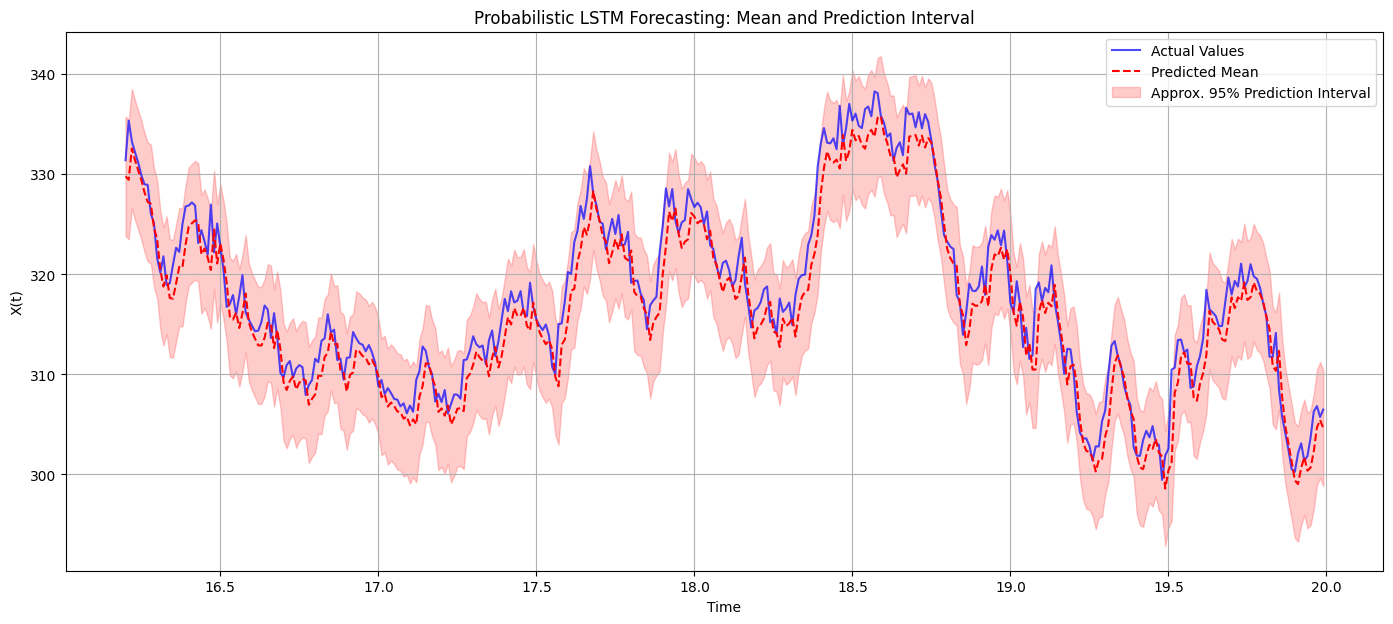

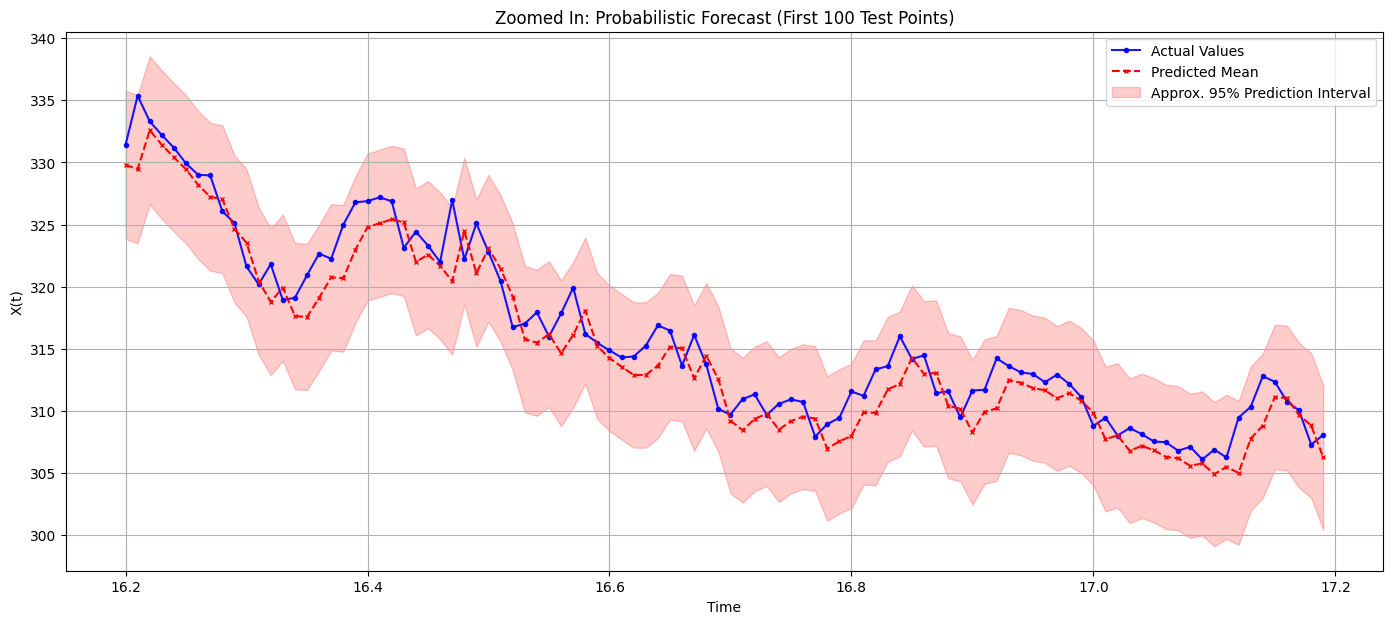

In [ ]:
model.eval()
predicted_means_scaled = []
predicted_std_devs_scaled = []
actual_values_scaled_eval = []

with torch.no_grad():
    for sequences, targets in test_loader:
        sequences, targets_batch = sequences.to(device), targets.to(device)
        output_params = model(sequences)

        mu_scaled = output_params[:, 0:1]
        log_var_scaled = output_params[:, 1:2]
        std_dev_scaled = torch.sqrt(torch.exp(log_var_scaled))

        predicted_means_scaled.extend(mu_scaled.cpu().numpy())
        predicted_std_devs_scaled.extend(std_dev_scaled.cpu().numpy())
        actual_values_scaled_eval.extend(targets_batch.cpu().numpy())

predicted_means_scaled = np.array(predicted_means_scaled)
predicted_std_devs_scaled = np.array(predicted_std_devs_scaled)
actual_values_scaled_eval = np.array(actual_values_scaled_eval)

# Inverse transform the means
predicted_means_orig = scaler.inverse_transform(predicted_means_scaled)
actual_values_orig_eval = scaler.inverse_transform(actual_values_scaled_eval)

# Inverse transform the standard deviations
if isinstance(scaler, MinMaxScaler):
    data_range = scaler.data_max_[0] - scaler.data_min_[0]
    predicted_std_devs_orig = predicted_std_devs_scaled * data_range
else:
    predicted_std_devs_orig = predicted_std_devs_scaled / scaler.scale_[0]

test_output_params_scaled = torch.cat(
    (torch.tensor(predicted_means_scaled), torch.log(torch.tensor(predicted_std_devs_scaled)**2)), dim=1
)
test_targets_scaled = torch.tensor(actual_values_scaled_eval)
final_test_nll = gaussian_nll_loss(test_output_params_scaled, test_targets_scaled).item()
print(f"Test Set Average NLL (scaled): {final_test_nll:.4f}")


# Plotting the results with prediction intervals
plt.figure(figsize=(17, 7))
time_axis_test = time_np[split_idx + sequence_length:]

plt.plot(time_axis_test, actual_values_orig_eval, label="Actual Values", alpha=0.7, color='blue')
plt.plot(time_axis_test, predicted_means_orig, label="Predicted Mean", linestyle='--', color='red')

# Confidence interval (e.g., 95%)
z_score = 1.96
upper_bound = predicted_means_orig + z_score * predicted_std_devs_orig
lower_bound = predicted_means_orig - z_score * predicted_std_devs_orig
plt.fill_between(time_axis_test, lower_bound.flatten(), upper_bound.flatten(),
                 color='red', alpha=0.2, label="Approx. 95% Prediction Interval")

plt.xlabel("Time")
plt.ylabel("X(t)")
plt.title("Probabilistic LSTM Forecasting: Mean and Prediction Interval")
plt.legend()
plt.grid(True)
plt.show()


# Zoom in
num_plot_points = 100
plt.figure(figsize=(17, 7))
plt.plot(time_axis_test[:num_plot_points],
         actual_values_orig_eval[:num_plot_points],
         label="Actual Values", alpha=0.9, color='blue', marker='o', markersize=3)
plt.plot(time_axis_test[:num_plot_points],
         predicted_means_orig[:num_plot_points],
         label="Predicted Mean", linestyle='--', color='red', marker='x', markersize=3)
plt.fill_between(time_axis_test[:num_plot_points],
                 lower_bound[:num_plot_points].flatten(),
                 upper_bound[:num_plot_points].flatten(),
                 color='red', alpha=0.2, label="Approx. 95% Prediction Interval")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.title(f"Zoomed In: Probabilistic Forecast (First {num_plot_points} Test Points)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true_orig_flat = actual_values_orig_eval.flatten()
y_pred_mean_orig_flat = predicted_means_orig.flatten()

mse_orig = mean_squared_error(y_true_orig_flat, y_pred_mean_orig_flat)
mae_orig = mean_absolute_error(y_true_orig_flat, y_pred_mean_orig_flat)

print(f"--- Evaluation Metrics (Original Scale) ---")
print(f"Test Set MSE: {mse_orig:.4f}")
print(f"Test Set MAE: {mae_orig:.4f}")



log_var_scaled_for_nll = np.log(predicted_std_devs_scaled**2 + 1e-8)
test_output_params_for_nll = torch.cat(
    (torch.tensor(predicted_means_scaled), torch.tensor(log_var_scaled_for_nll)), dim=1
)
test_targets_for_nll = torch.tensor(actual_values_scaled_eval)


final_test_nll = gaussian_nll_loss(test_output_params_for_nll.to(device), test_targets_for_nll.to(device)).item()
print(f"\n--- Probabilistic Metrics ---")
print(f"Test Set Average NLL (scaled): {final_test_nll:.4f}")

# PICP and AWPI (on original scale)
z_score = 1.96 # For 95% interval
lower_bound_orig = y_pred_mean_orig_flat - z_score * predicted_std_devs_orig.flatten()
upper_bound_orig = y_pred_mean_orig_flat + z_score * predicted_std_devs_orig.flatten()

picp = np.mean((y_true_orig_flat >= lower_bound_orig) & (y_true_orig_flat <= upper_bound_orig)) * 100
print(f"Test Set PICP (95% nominal): {picp:.2f}%")

awpi = np.mean(upper_bound_orig - lower_bound_orig)
print(f"Test Set AWPI (95% interval): {awpi:.4f}")


--- Evaluation Metrics (Original Scale) ---
Test Set MSE: 6.4156
Test Set MAE: 2.0114

--- Probabilistic Metrics ---
Test Set Average NLL (scaled): -3.0759
Test Set PICP (95% nominal): 97.37%
Test Set AWPI (95% interval): 11.7374
